In [ ]:
# %%
import os
import math
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm.auto import tqdm
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import joblib
import pyreadr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ==========================================
# 1. Configuration & Setup
# ==========================================

# --- ANALYSIS MODE ---
# "RNA_RNA"  = Co-expression (Recommended).
# "RNA_ATAC" = Epigenetic Regulation.
ANALYSIS_MODE = "RNA_RNA"

# --- Visual Theme Settings ---
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['pdf.fonttype'] = 42

# --- Paths & Parameters ---
outdir = Path(
    "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline")
adata_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"
dorothea_rda = "/mnt/home3/miska/nm667/scratch/inProgress/dev/scripts/dorothea_hs.rda"

# --- Gene List ---
TARGET_GENES = list(set([
    "AOC1", "DPEP1", "CYFIP2", "TM7SF3", "SLC9A3", "ACAT1", "HOXA9", "LGALS2",
    "CUBN", "SLC2A9", "EFHD1", "IL1RL1", "ALDH8A1", "BICC1", "PEPD", "SLC17A3",
    "ARMC7", "PAX8", "ALDOB", "ENPEP", "OCIAD2", "CRB2", "SLC5A10", "KCNJ15",
    "BDH2", "AMN", "ACSF2", "SOST", "UMOD", "SHMT1", "SHMT1", "TCN2", "BCAM",
    "MME", "AC092653.5", "RGL3", "TDGF1", "ACY1",
    
    # Disease / Fibrosis Markers (ADDED TO FIND SOX9)
    "HAVCR1", "VIM", "FN1", "COL1A1", "VCAM1", "PROM1", "CD24",
    "CCL2", "TNF", "ICAM1", "DCN", "ACTA2",

    # Key TFs (to see self-regulation)
    "HNF4A", "PPARA", "SOX9", "RELB", "TWIST1", "SNAI1", "JUN", "FOS"
]))

# Parameters
cluster_col = "Cluster_Idents_New2"
# <--- UPDATE THIS if your column is named differently (e.g. 'disease')
condition_col = "diseasetype"
TOP_TF_COUNT = 50
outdir.mkdir(parents=True, exist_ok=True)

# Logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s: %(message)s")

# ==========================================
# 2. Helper Functions
# ==========================================


def get_matrix_df(adata_obj):
    if hasattr(adata_obj, "raw") and adata_obj.raw is not None:
        mat = adata_obj.raw.X
        cols = adata_obj.raw.var_names
    else:
        mat = adata_obj.X
        cols = adata_obj.var_names

    if hasattr(mat, "toarray"):
        mat = mat.toarray()

    return pd.DataFrame(mat, index=adata_obj.obs_names, columns=cols)


def fetch_dorothea_local(rda_path):
    if not os.path.exists(rda_path):
        return None
    r = pyreadr.read_r(rda_path)
    df = r[list(r.keys())[0]]
    if "confidence" in df.columns:
        df = df[df["confidence"].isin(["A", "B", "C"])]
    if "source" in df.columns:
        df = df.rename(columns={"source": "tf"})
    return df


def get_dotplot_data(adata, features, cluster_col):
    clusters = adata.obs[cluster_col].unique()
    mean_df = pd.DataFrame(index=clusters, columns=features)
    pct_df = pd.DataFrame(index=clusters, columns=features)

    for cl in clusters:
        cells = adata.obs.index[adata.obs[cluster_col] == cl]
        if hasattr(adata.raw, "X"):
            sub_X = adata.raw[cells, features].X
        else:
            sub_X = adata[cells, features].X
        if hasattr(sub_X, "toarray"):
            sub_X = sub_X.toarray()

        mean_df.loc[cl] = np.mean(sub_X, axis=0)
        pct_df.loc[cl] = np.mean(sub_X > 0, axis=0)

    return mean_df.astype(float), pct_df.astype(float)


def draw_dotplot(ax, mean_df, pct_df, title, cmap="Reds"):
    mean_data = mean_df.T
    pct_data = pct_df.T
    y_labels = mean_data.index
    x_labels = mean_data.columns

    x, y = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))
    sc = ax.scatter(x.flatten(), y.flatten(), s=pct_data.values.flatten()*100*2,
                    c=mean_data.values.flatten(), cmap=cmap,
                    norm=mcolors.Normalize(
                        vmin=0, vmax=np.percentile(mean_data.values, 99)),
                    edgecolors='none')

    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels, rotation=45, ha="left", fontsize=10)
    ax.xaxis.tick_top()
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=9)
    ax.set_title(title, pad=20, fontsize=14)
    ax.set_xlim(-0.5, len(x_labels)-0.5)
    ax.set_ylim(-0.5, len(y_labels)-0.5)
    ax.invert_yaxis()
    return sc


# ==========================================
# 3. Data Loading & Preprocessing
# ==========================================
logging.info(f"Reading h5ad: {adata_path}")
adata = sc.read_h5ad(adata_path)

if "tech" not in adata.obs.columns:
    raise KeyError("adata.obs missing 'tech'")

rna_mask = adata.obs["tech"].isin(["SN_RNA", "SC_RNA"])
atac_mask = adata.obs["tech"].str.contains("ATAC", case=False, na=False)

adata_rna = adata[rna_mask].copy()
adata_atac = adata[atac_mask].copy()

rna_df = get_matrix_df(adata_rna)
atac_df = get_matrix_df(adata_atac)

# --- PSEUDO-BULK AGGREGATION ---
logging.info("Aggregating...")

if condition_col in adata.obs.columns:
    agg_col = 'group_id'
    adata_rna.obs[agg_col] = adata_rna.obs[cluster_col].astype(
        str) + "_" + adata_rna.obs[condition_col].astype(str)
    adata_atac.obs[agg_col] = adata_atac.obs[cluster_col].astype(
        str) + "_" + adata_atac.obs[condition_col].astype(str)
else:
    logging.warning(
        f"Condition '{condition_col}' not found. Using Cluster only.")
    agg_col = cluster_col

rna_cluster = rna_df.join(adata_rna.obs[agg_col]).groupby(agg_col).mean()
atac_cluster = atac_df.join(adata_atac.obs[agg_col]).groupby(agg_col).mean()

shared_groups = sorted(
    list(set(rna_cluster.index).intersection(set(atac_cluster.index))))
rna_df_agg = rna_cluster.loc[shared_groups]
atac_df_agg = atac_cluster.loc[shared_groups]

logging.info(
    f"✅ Aggregated Shapes -> RNA: {rna_df_agg.shape}, ATAC: {atac_df_agg.shape}")
dorothea = fetch_dorothea_local(dorothea_rda)

# ==========================================
# 4. TF-Gene Correlation Pipeline
# ==========================================
logging.info(f"Running Correlation Analysis (Mode: {ANALYSIS_MODE})...")

if dorothea is not None:
    tfs = sorted(set(dorothea["tf"]) & set(rna_df_agg.columns))
else:
    tfs = [c for c in rna_df_agg.columns if c.isupper()][:500]

target_df = atac_df_agg if ANALYSIS_MODE == "RNA_ATAC" else rna_df_agg
genes_present = [g for g in TARGET_GENES if g in target_df.columns]

tf_gene_results = []
for gene in tqdm(genes_present, desc="Correlating"):
    gene_vec = target_df[gene].values
    for tf in tfs:
        tf_vec = rna_df_agg[tf].values
        r, p = spearmanr(tf_vec, gene_vec, nan_policy="omit")
        if not np.isnan(r):
            tf_gene_results.append(
                {"tf": tf, "gene": gene, "spearman": r, "pval": p})

corr_df = pd.DataFrame(tf_gene_results)
if not corr_df.empty:
    corr_df["abs_r"] = corr_df["spearman"].abs()
    corr_df["fdr"] = multipletests(corr_df["pval"], method="fdr_bh")[1]
    corr_df.to_csv(outdir / "tf_gene_correlations.csv", index=False)
    sig = corr_df.query("fdr < 0.05")
    sig.to_csv(outdir / "tf_gene_significant.csv", index=False)
    logging.info(f"✅ Significant TF-Gene pairs: {sig.shape}")
else:
    logging.warning("No significant correlations found.")
    sig = pd.DataFrame()


2025-12-29 14:17:41,162 INFO: Reading h5ad: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad


2025-12-29 14:04:00,908 INFO: Generating Visualization...
/mnt/home3/miska/nm667/miniconda3/envs/cosmaxSpatial/lib/python3.13/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)
/mnt/home3/miska/nm667/miniconda3/envs/cosmaxSpatial/lib/python3.13/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)
2025-12-29 14:04:07,121 INFO: 💾 Saving Plot Data to CSV...
2025-12-29 14:04:07,170 INFO:    Saved Plot 1 Data: /mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline/Plot1_TF_Expression_Mean.csv
2025-12-29 14:04:07,170 INFO:    Saved Plot 2 Data: /mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline/Plot2_Target_Gene_Expression_Mean.csv
2025-12-29 14:

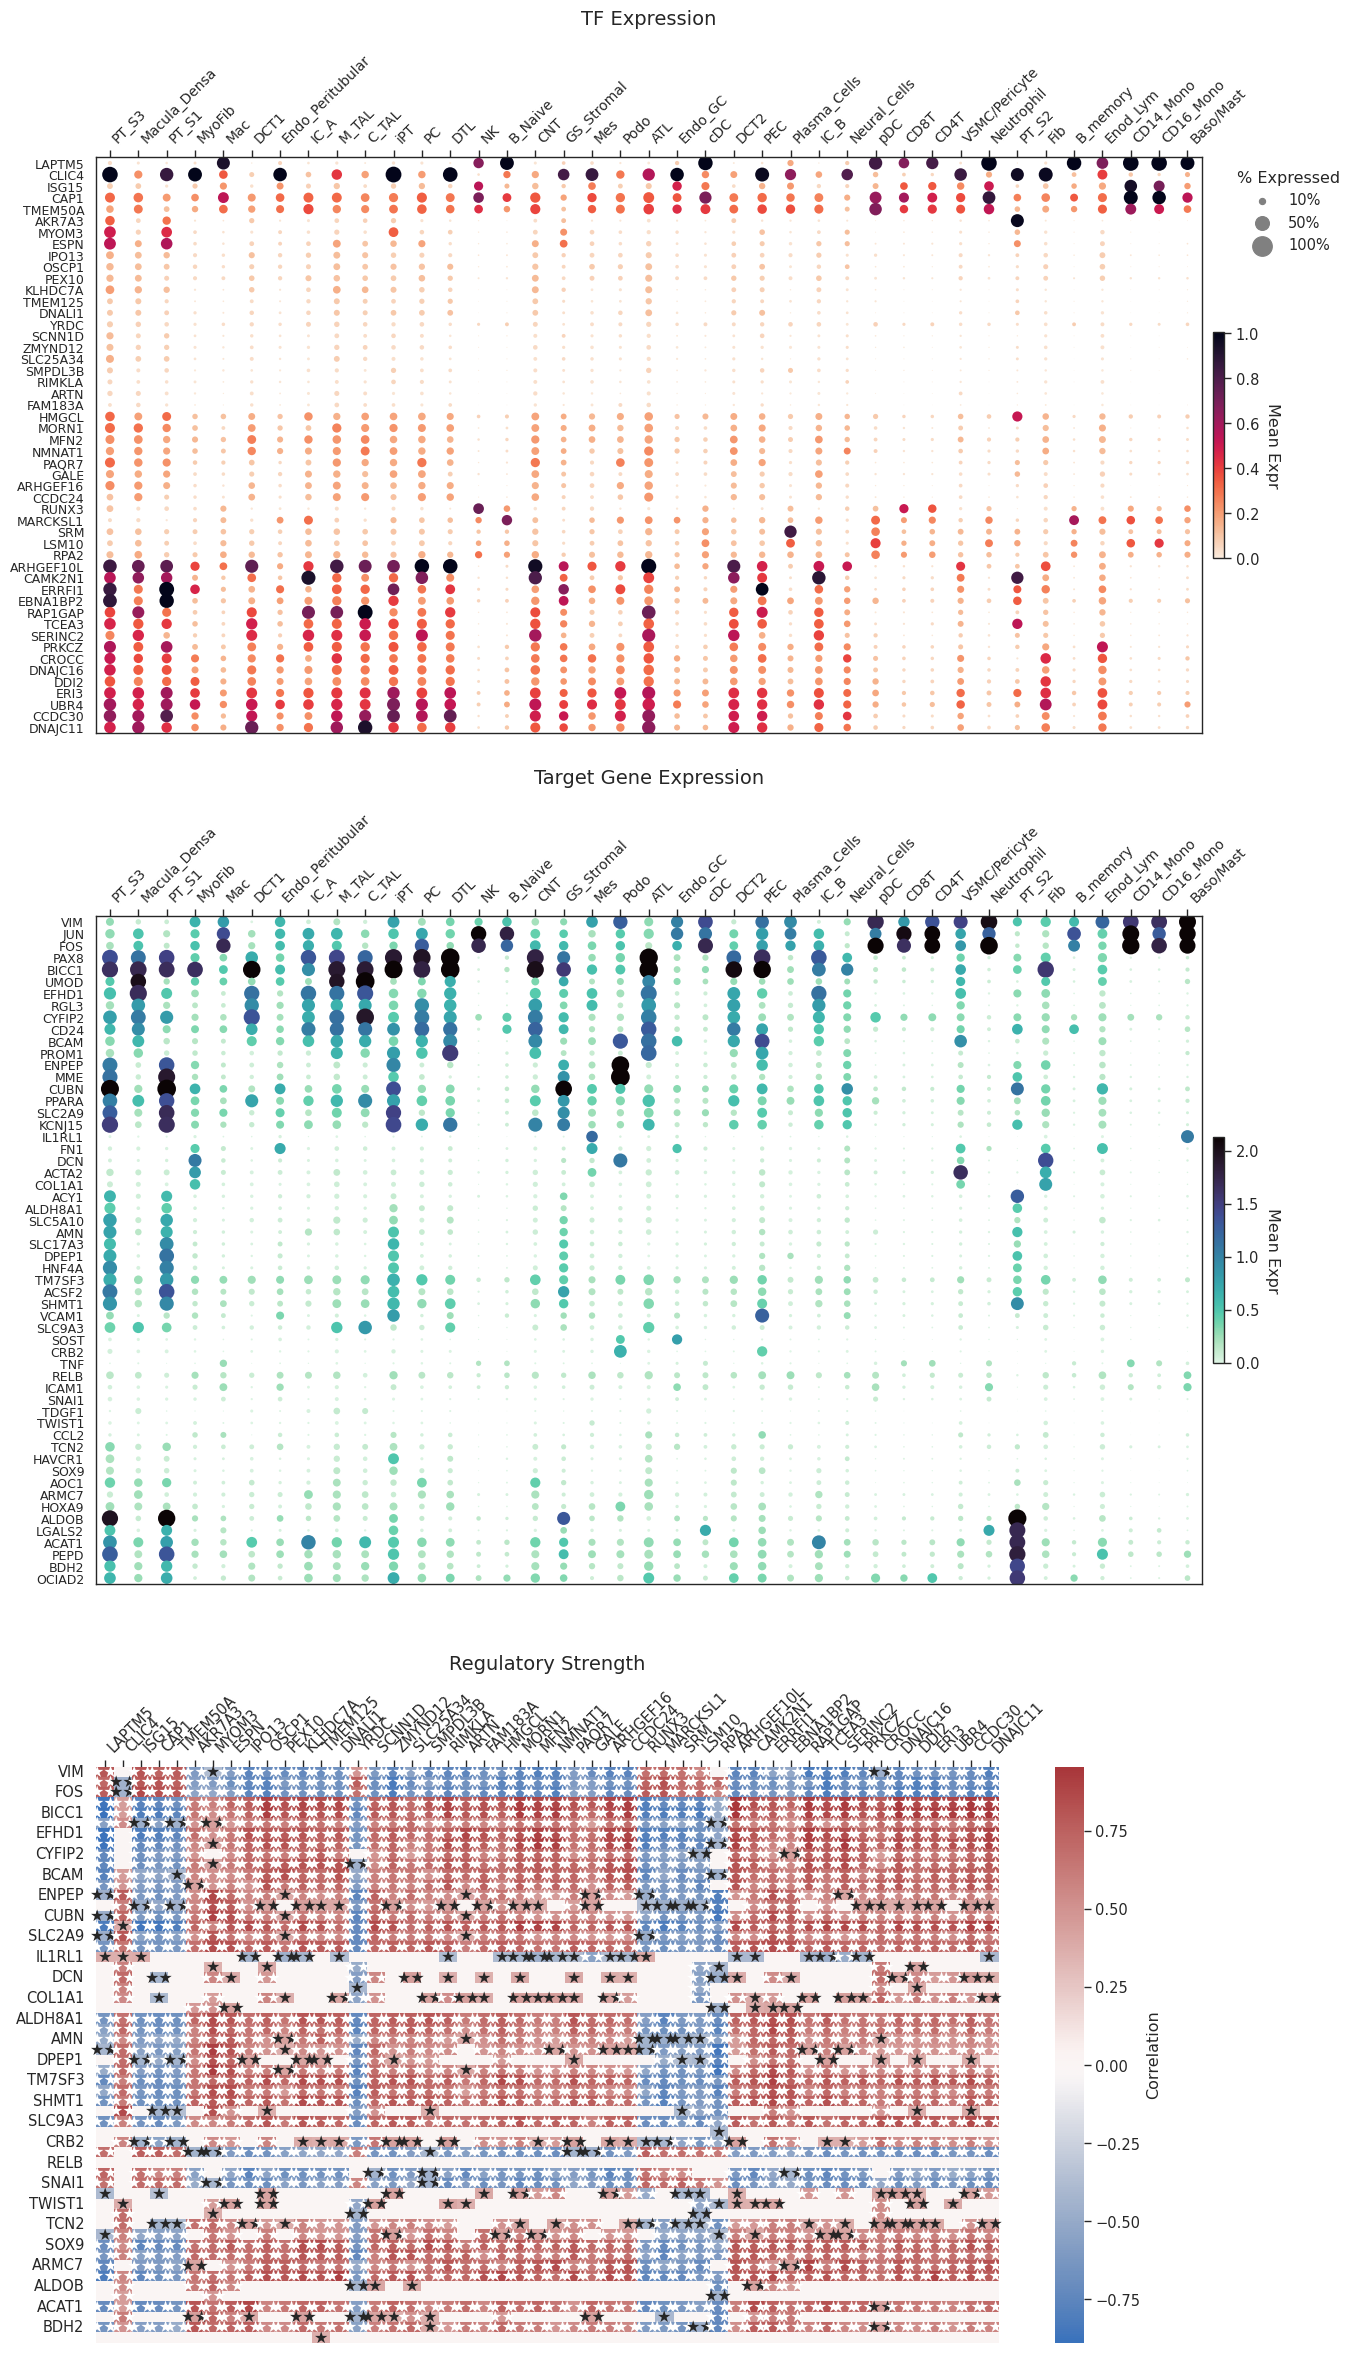

In [ ]:

# ==========================================
# 5. Visualization & Data Saving
# ==========================================
if not sig.empty:
    logging.info("Generating Visualization...")

    # 1. Select Data
    top_tfs = sig.groupby("tf")["spearman"].median().abs().sort_values(
        ascending=False).head(TOP_TF_COUNT).index.tolist()
    valid_tfs = [t for t in top_tfs if t in adata.raw.var_names]
    valid_genes = genes_present

    # 2. Compute Dot Plot Stats
    tf_mean, tf_pct = get_dotplot_data(adata, valid_tfs, cluster_col)
    gene_mean, gene_pct = get_dotplot_data(adata, valid_genes, cluster_col)

    # 3. Cluster & Order
    def quick_order(df):
        if df.shape[1] < 2:
            return df.columns
        cg = sns.clustermap(np.log1p(df).T, cmap="viridis", figsize=(1, 1))
        o = cg.dendrogram_row.reordered_ind
        plt.close("all")
        return df.columns[o]

    ordered_tfs = quick_order(tf_mean)
    ordered_genes = quick_order(gene_mean)

    # Reorder
    tf_mean = tf_mean[ordered_tfs]
    tf_pct = tf_pct[ordered_tfs]
    gene_mean = gene_mean[ordered_genes]
    gene_pct = gene_pct[ordered_genes]

    # --- SAVE PLOT DATA (NEW SECTION) ---
    logging.info("💾 Saving Plot Data to CSV...")
    tf_mean.to_csv(outdir / "Plot1_TF_Expression_Mean.csv")
    tf_pct.to_csv(outdir / "Plot1_TF_Expression_Pct.csv")
    gene_mean.to_csv(outdir / "Plot2_Target_Gene_Expression_Mean.csv")
    gene_pct.to_csv(outdir / "Plot2_Target_Gene_Expression_Pct.csv")
    logging.info(
        f"   Saved Plot 1 Data: {outdir}/Plot1_TF_Expression_Mean.csv")
    logging.info(
        f"   Saved Plot 2 Data: {outdir}/Plot2_Target_Gene_Expression_Mean.csv")

    # 4. Plotting
    fig, axes = plt.subplots(3, 1, figsize=(
        14, 24), height_ratios=[2.5, 2.9, 2.5])

    # Plot 1
    sc1 = draw_dotplot(axes[0], tf_mean, tf_pct, "TF Expression", "rocket_r")
    plt.colorbar(sc1, ax=axes[0], fraction=0.01, pad=0.01).set_label(
        "Mean Expr", rotation=270, labelpad=15)

    # Plot 2
    sc2 = draw_dotplot(axes[1], gene_mean, gene_pct,
                       "Target Gene Expression", "mako_r")
    plt.colorbar(sc2, ax=axes[1], fraction=0.01, pad=0.01).set_label(
        "Mean Expr", rotation=270, labelpad=15)

    # Plot 3 (Heatmap)
    corr_mat = sig.pivot_table(index="gene", columns="tf", values="spearman").reindex(
        index=ordered_genes, columns=ordered_tfs).fillna(0)
    pval_mat = sig.pivot_table(index="gene", columns="tf", values="pval").reindex(
        index=ordered_genes, columns=ordered_tfs)

    sig_mask = pval_mat.copy().astype(str)
    sig_mask[:] = ""
    for g in ordered_genes:
        for t in ordered_tfs:
            try:
                if pval_mat.loc[g, t] < 0.01:
                    sig_mask.loc[g, t] = "★★"
                elif pval_mat.loc[g, t] < 0.05:
                    sig_mask.loc[g, t] = "★"
            except:
                pass

    sns.heatmap(corr_mat, cmap="vlag", center=0, annot=sig_mask,
                fmt="", ax=axes[2], cbar_kws={"label": "Correlation"})
    axes[2].set_title("Regulatory Strength", fontsize=14, pad=10)
    axes[2].xaxis.tick_top()
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="left")

    # Legend
    legend_elements = [plt.scatter(
        [], [], s=x*2, c='gray', label=f'{x}%') for x in [10, 50, 100]]
    axes[0].legend(handles=legend_elements, title="% Expressed",
                   bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    plt.tight_layout(pad=2.0)
    plt.savefig(outdir / "TF_Gene_Analysis.png", dpi=300, bbox_inches='tight')
    plt.savefig(outdir / "TF_Gene_Analysis.pdf", dpi=300, bbox_inches='tight')
    logging.info(f"✅ Plots saved to: {outdir}")
    plt.show()


In [ ]:
print(adata)


AnnData object with n_obs × n_vars = 588177 × 3000
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'percent_mt', 'tech', 'proj', 'dataSource', 'library_id', 'specimen_id', 'region', 'percent.cortex', 'percent.medulla', 'cluster_id', 'UMAP_1', 'UMAP_2', 'sampletype', 'umap1', 'umap2', 'SpecimenID', 'diseasetype', 'age', 'gender', 'state', 'tissuetype', 'celltype', 'Cluster_Idents_New2', 'StudyName'
    var: 'vst.mean-0', 'vst.variance-0', 'vst.variance.expected-0', 'vst.variance.standardized-0', 'vst.variable-0', 'vst.mean-1', 'vst.variance-1', 'vst.variance.expected-1', 'vst.variance.standardized-1', 'vst.variable-1', 'name-2', 'vst.mean-3', 'vst.variance-3', 'vst.variance.expected-3', 'vst.variance.standardized-3', 'vst.variable-3', 'vst.mean-4', 'vst.variance-4', 'vst.variance.expected-4', 'vst.variance.standardized-4', 'vst.variable-4', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Cluster_Ide

2025-12-29 14:05:48,812 INFO: Reading: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad
2025-12-29 14:06:16,415 INFO: Filtering for scRNA-seq/snRNA-seq only...
2025-12-29 14:06:20,430 INFO: ✅ Subset created: 533704 RNA cells (ATAC cells removed).
2025-12-29 14:06:20,432 INFO: Calculating expression stats...
2025-12-29 14:06:20,433 WARNING: ⚠️ Genes not found in RNA data: {'AC092653.5'}
2025-12-29 14:06:22,768 INFO: ✅ Data saved to /mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline/Target_Genes_scRNA_Mean.csv
2025-12-29 14:06:22,769 INFO: Generating Dot Plot...
2025-12-29 14:06:31,392 INFO: maxp pruned
2025-12-29 14:06:31,405 INFO: cmap pruned
2025-12-29 14:06:31,405 INFO: kern dropped
2025-12-29 14:06:31,406 INFO: post pruned
2025-12-29 14:06:31,406 INFO: FFTM dropped
2025-12-29 14:06:31,409 INFO: GPOS pruned
2025-12-29 14:06:31,412 INFO: GSUB pruned
2025-12-29 14:06:31,417 INFO: glyf pruned
2025-

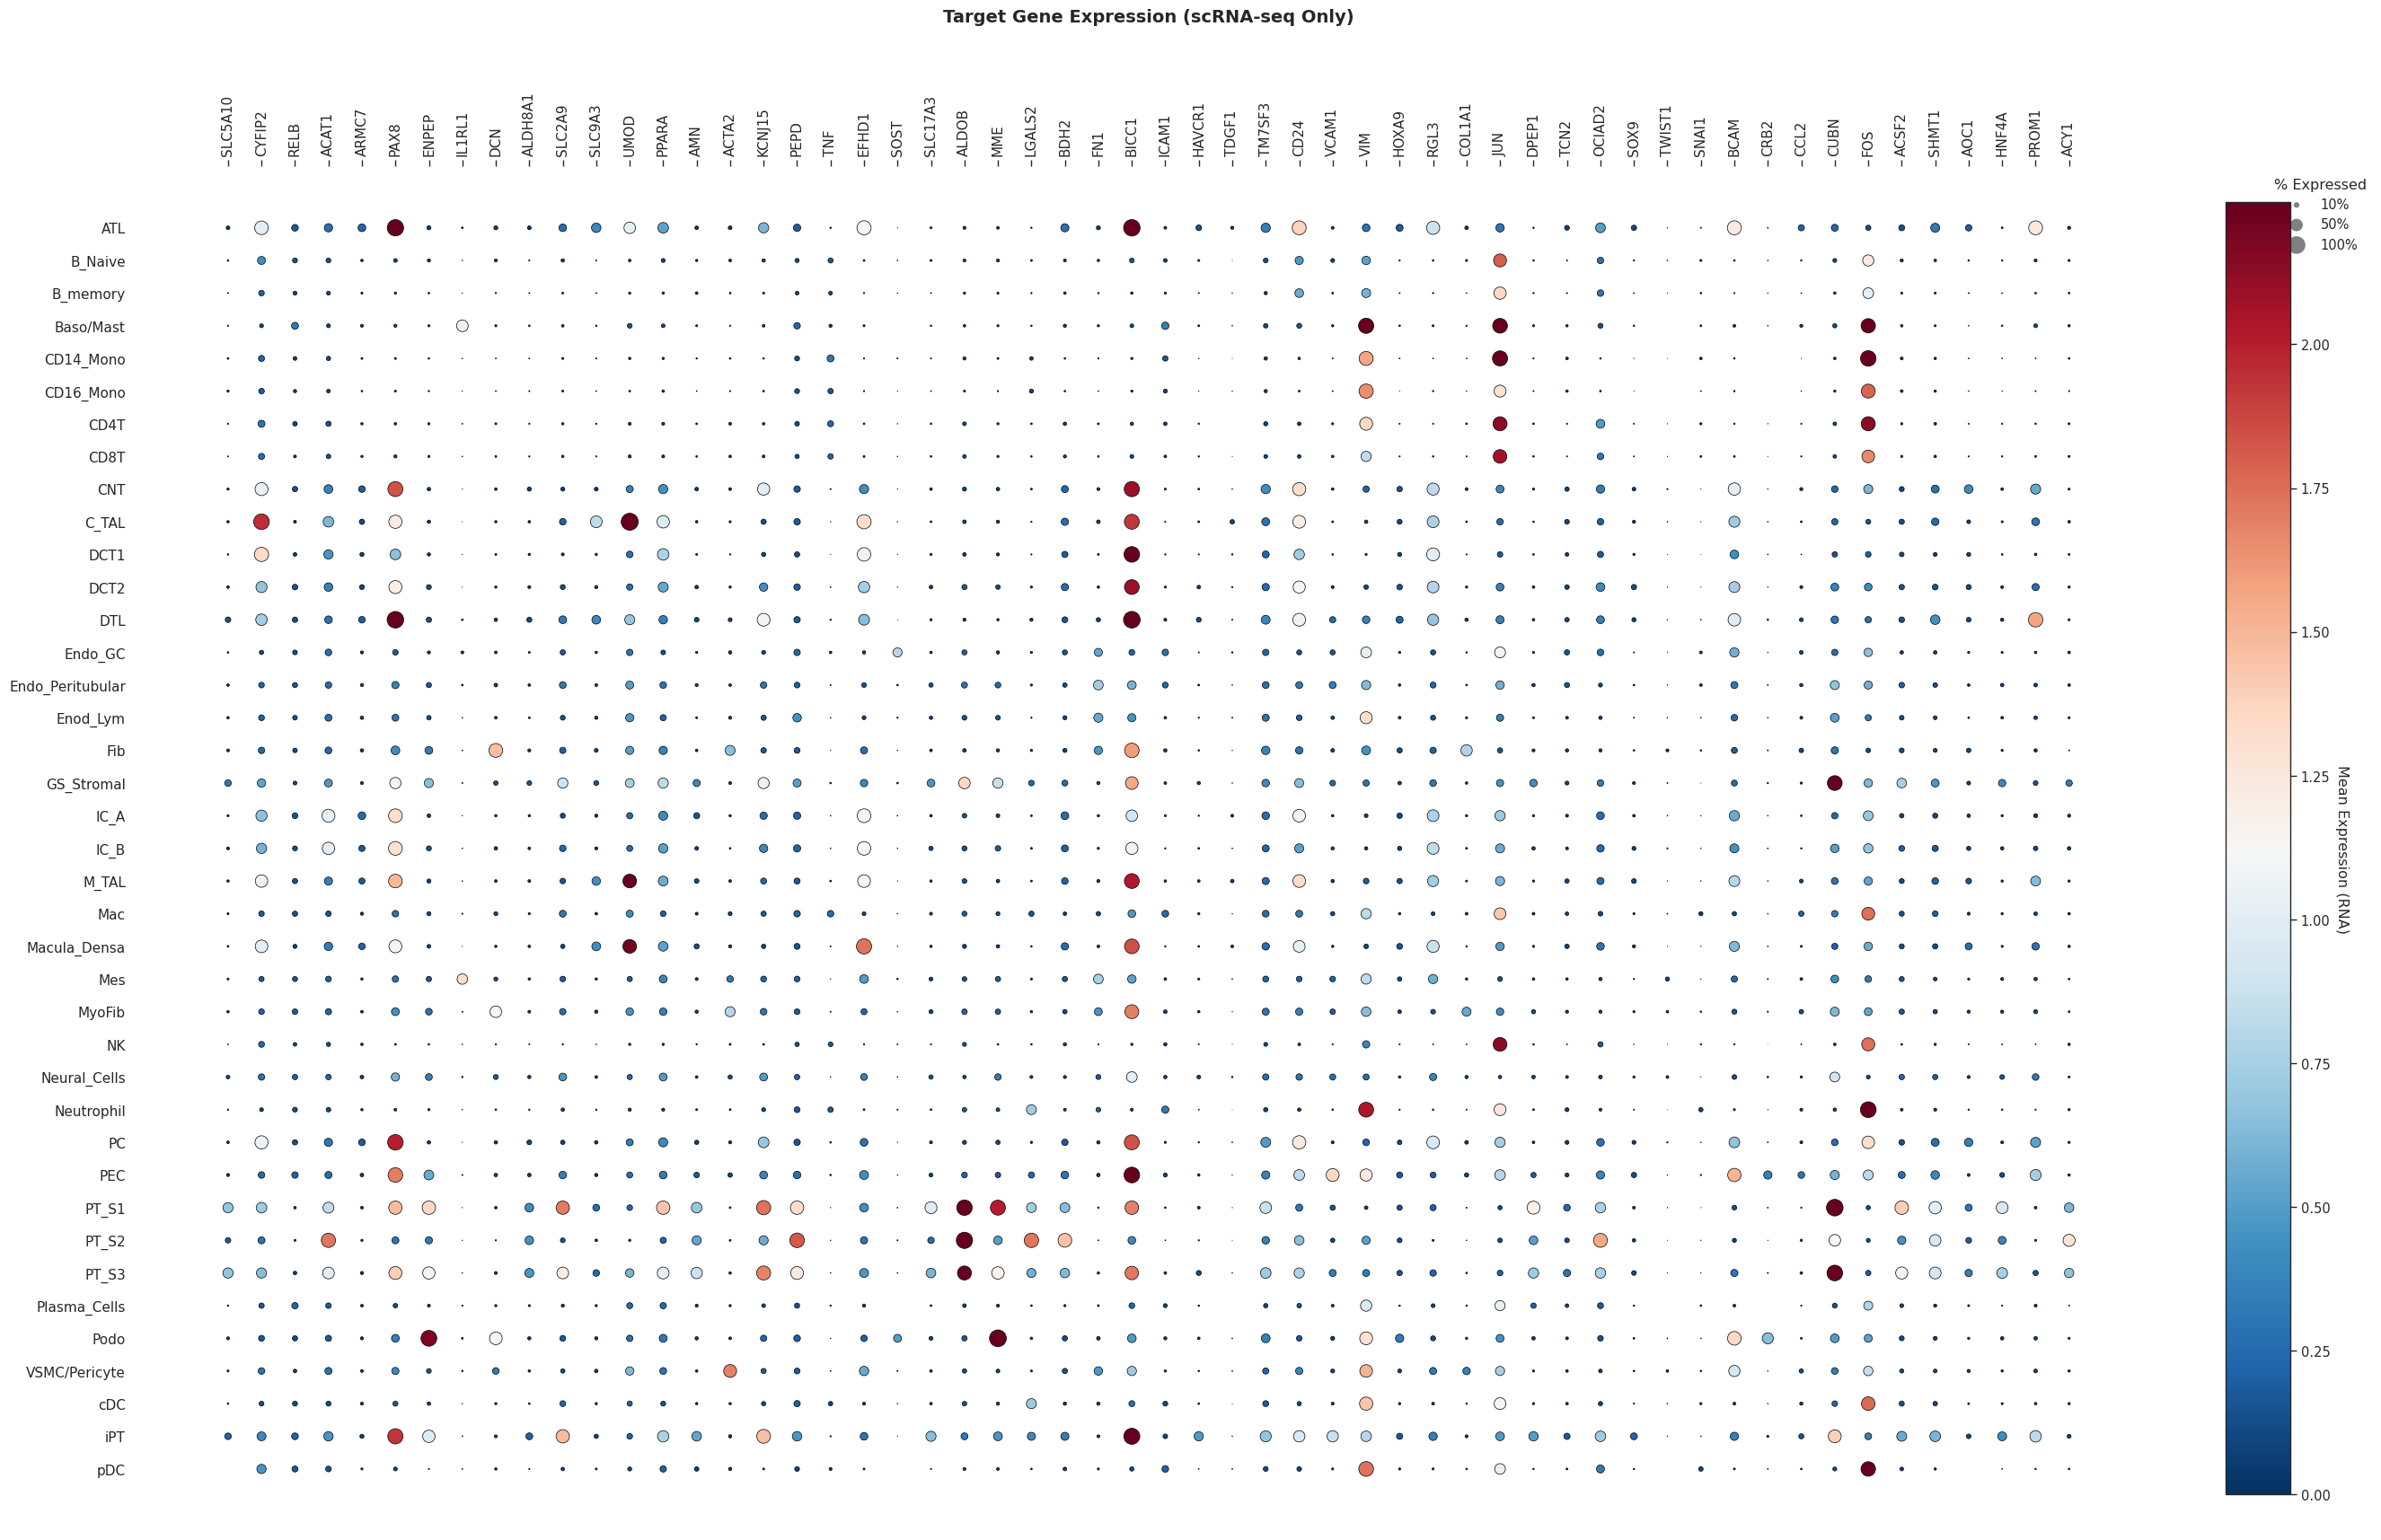

In [ ]:
# %%
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ==========================================
# 1. Setup & Paths
# ==========================================
# Define your paths
outdir = Path(
    "/mnt/home3/miska/nm667/scratch/inProgress/dev/figr_cluster_pipeline")
adata_path = "/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad"

# Analysis Parameters
# The column with cell types (e.g., PT, TAL, PT-Injured)
cluster_col = "Cluster_Idents_New2"

# Gene List (Ordered Biologically for the Plot)
ORDERED_GENES = list(set([
    "AOC1", "DPEP1", "CYFIP2", "TM7SF3", "SLC9A3", "ACAT1", "HOXA9", "LGALS2",
    "CUBN", "SLC2A9", "EFHD1", "IL1RL1", "ALDH8A1", "BICC1", "PEPD", "SLC17A3",
    "ARMC7", "PAX8", "ALDOB", "ENPEP", "OCIAD2", "CRB2", "SLC5A10", "KCNJ15",
    "BDH2", "AMN", "ACSF2", "SOST", "UMOD", "SHMT1", "SHMT1", "TCN2", "BCAM",
    "MME", "AC092653.5", "RGL3", "TDGF1", "ACY1",

    # Disease / Fibrosis Markers (ADDED TO FIND SOX9)
    "HAVCR1", "VIM", "FN1", "COL1A1", "VCAM1", "PROM1", "CD24",
    "CCL2", "TNF", "ICAM1", "DCN", "ACTA2",

    # Key TFs (to see self-regulation)
    "HNF4A", "PPARA", "SOX9", "RELB", "TWIST1", "SNAI1", "JUN", "FOS"
]))


2025-12-29 14:09:49,545 INFO: Reading: /mnt/home3/miska/nm667/scratch/inProgress/dev/data/Kidney_SC/GSE211785_Susztak_KPMP_SC_SN_ATAC_merged_PostSCVI_final.h5ad
2025-12-29 14:10:16,653 INFO: Filtering for scRNA-seq/snRNA-seq only...
2025-12-29 14:10:22,269 INFO: ✅ Kept 533704 RNA cells.
2025-12-29 14:10:22,272 INFO: Calculating expression stats...
2025-12-29 14:10:25,447 INFO: Generating Transposed Dot Plot...
2025-12-29 14:10:34,362 INFO: maxp pruned
2025-12-29 14:10:34,371 INFO: cmap pruned
2025-12-29 14:10:34,371 INFO: kern dropped
2025-12-29 14:10:34,372 INFO: post pruned
2025-12-29 14:10:34,372 INFO: FFTM dropped
2025-12-29 14:10:34,375 INFO: GPOS pruned
2025-12-29 14:10:34,378 INFO: GSUB pruned
2025-12-29 14:10:34,383 INFO: glyf pruned
2025-12-29 14:10:34,384 INFO: Added gid0 to subset
2025-12-29 14:10:34,384 INFO: Added first four glyphs to subset
2025-12-29 14:10:34,385 INFO: Closing glyph list over 'MATH': 66 glyphs before
2025-12-29 14:10:34,385 INFO: Glyph names: ['.notdef',

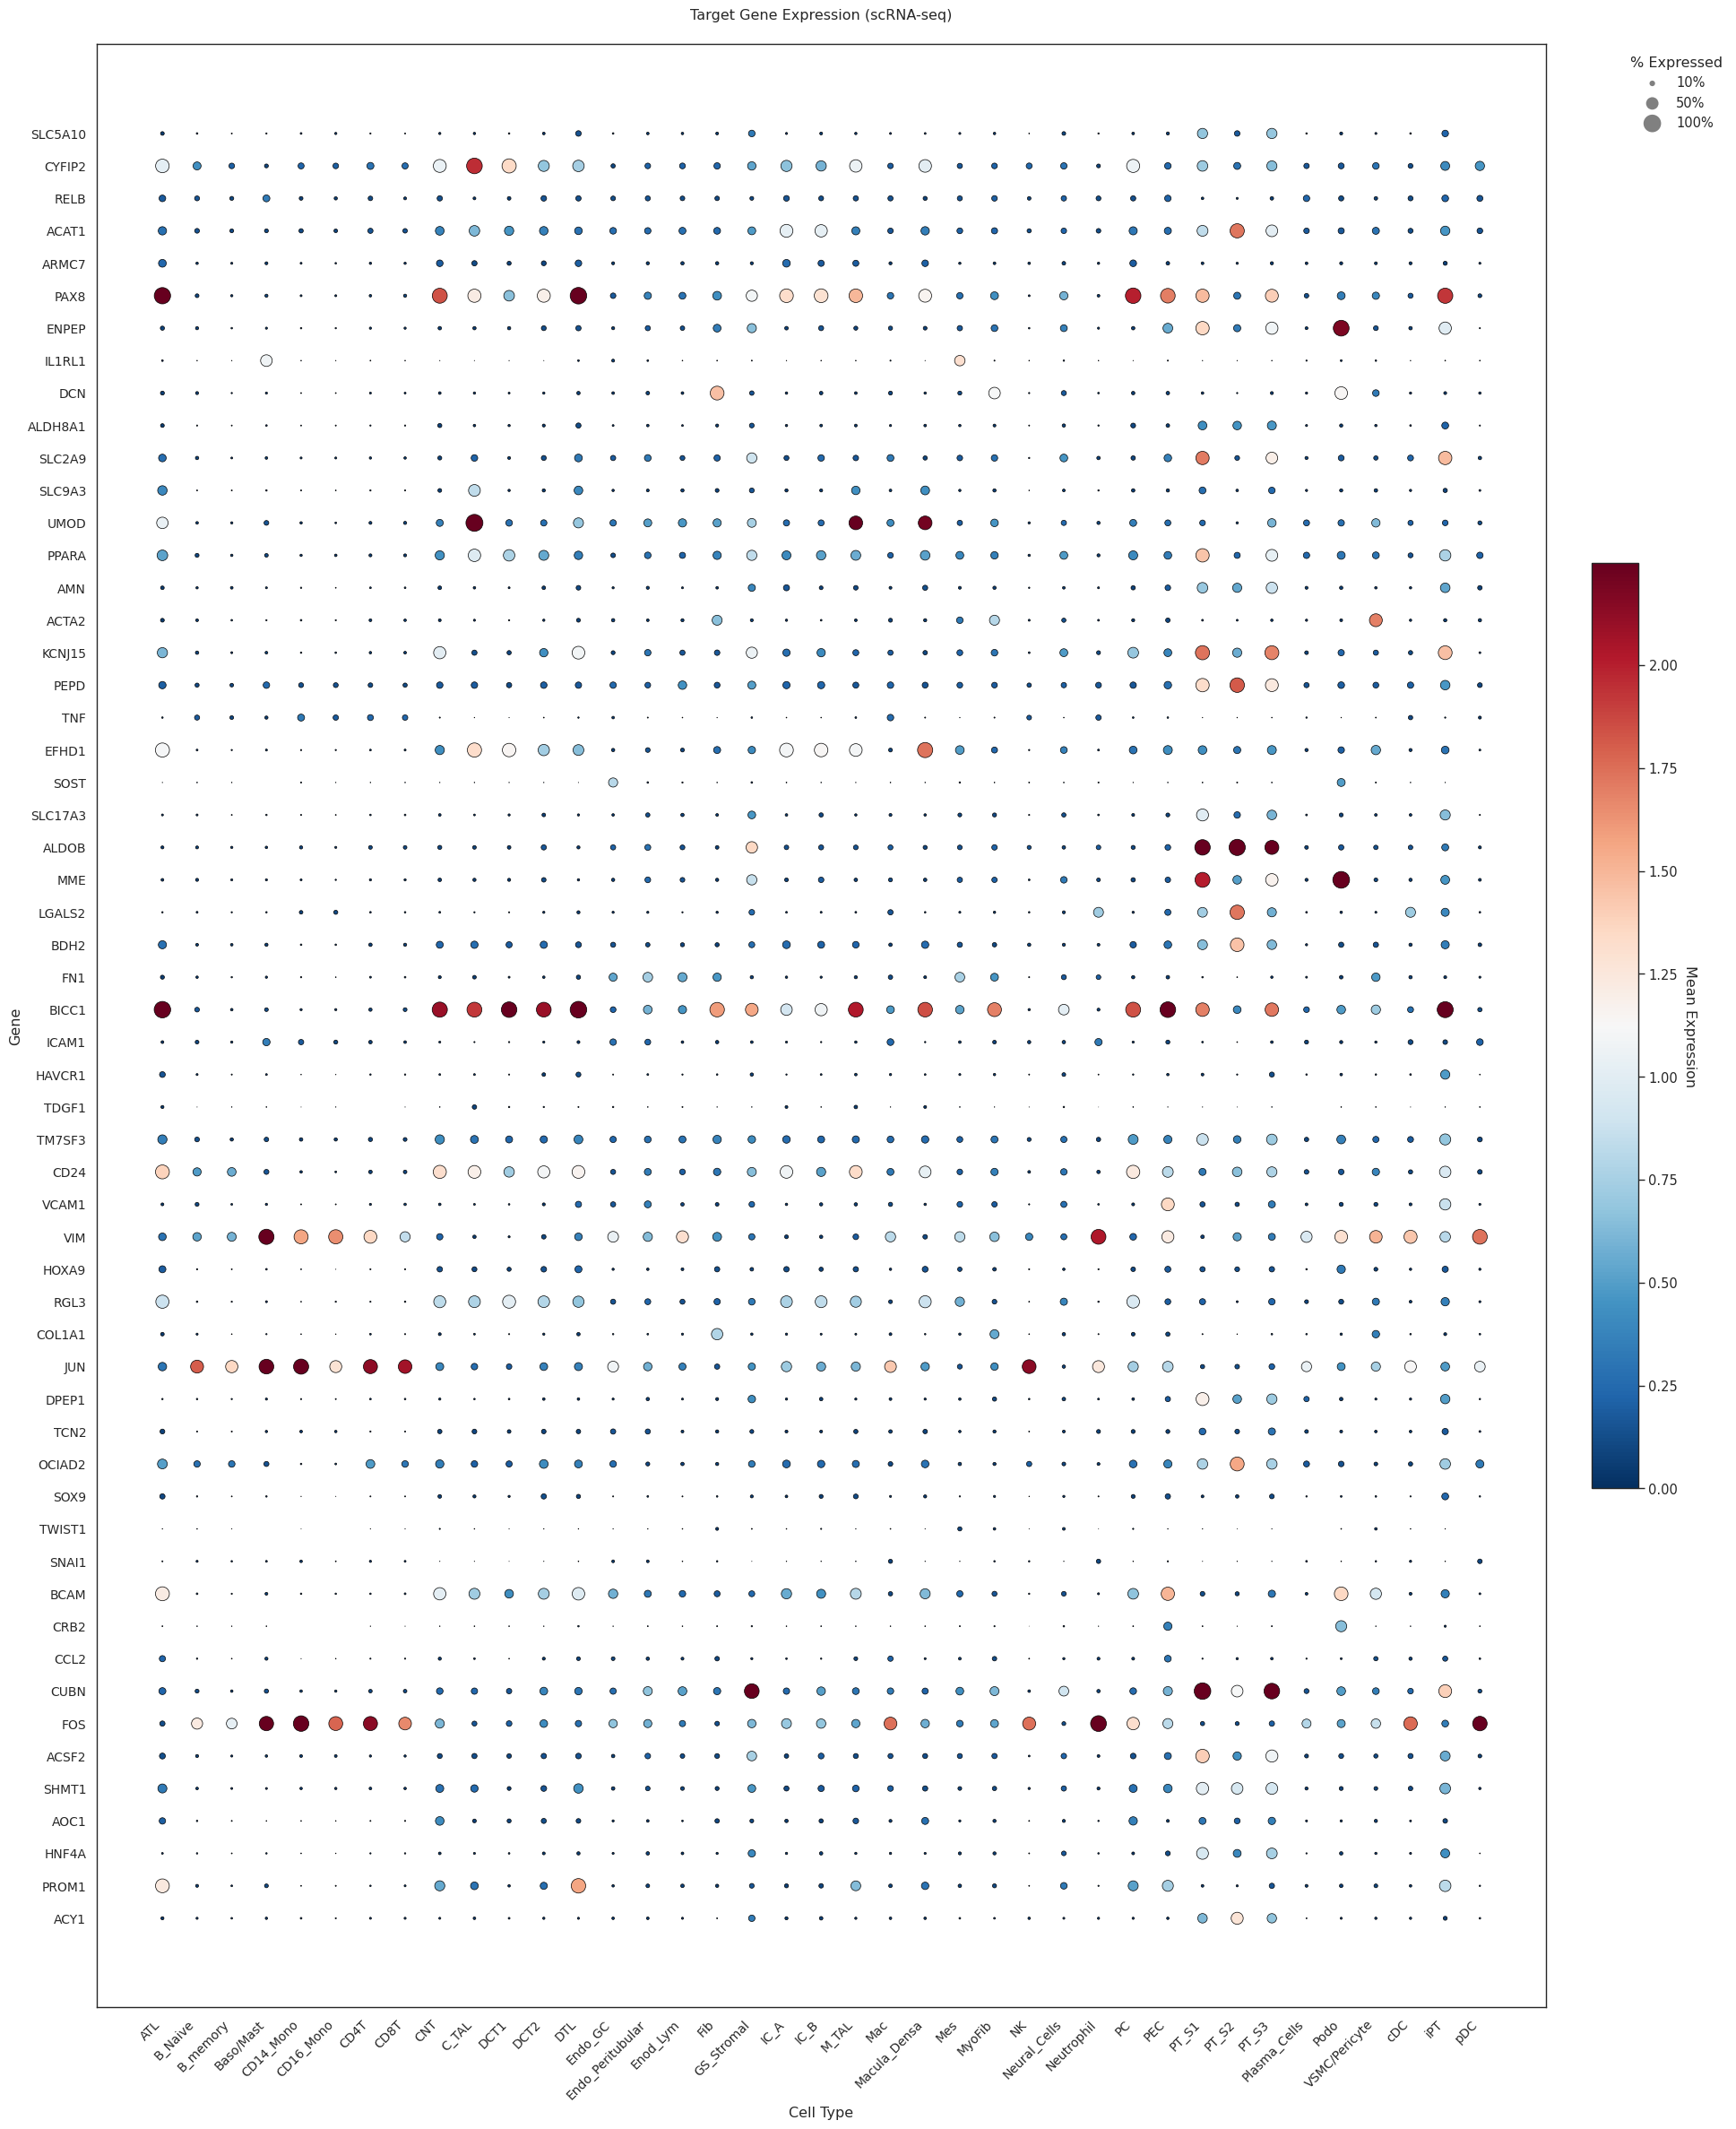

In [ ]:
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)
outdir.mkdir(parents=True, exist_ok=True)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

# ==========================================
# 2. Load & Filter Data (RNA Only)
# ==========================================
logging.info(f"Reading: {adata_path}")
adata = sc.read_h5ad(adata_path)

logging.info("Filtering for scRNA-seq/snRNA-seq only...")
if "tech" in adata.obs.columns:
    adata_rna = adata[adata.obs["tech"].isin(["SN_RNA", "SC_RNA"])].copy()
    logging.info(f"✅ Kept {adata_rna.n_obs} RNA cells.")
else:
    logging.warning("⚠️ 'tech' column missing. Assuming all data is RNA.")
    adata_rna = adata.copy()


2025-12-29 14:11:46,902 INFO: Calculating expression stats...
2025-12-29 14:11:49,721 INFO: Generating Transposed Dot Plot...
2025-12-29 14:11:58,411 INFO: maxp pruned
2025-12-29 14:11:58,420 INFO: cmap pruned
2025-12-29 14:11:58,420 INFO: kern dropped
2025-12-29 14:11:58,421 INFO: post pruned
2025-12-29 14:11:58,422 INFO: FFTM dropped
2025-12-29 14:11:58,424 INFO: GPOS pruned
2025-12-29 14:11:58,427 INFO: GSUB pruned
2025-12-29 14:11:58,432 INFO: glyf pruned
2025-12-29 14:11:58,433 INFO: Added gid0 to subset
2025-12-29 14:11:58,434 INFO: Added first four glyphs to subset
2025-12-29 14:11:58,434 INFO: Closing glyph list over 'MATH': 66 glyphs before
2025-12-29 14:11:58,435 INFO: Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenrigh

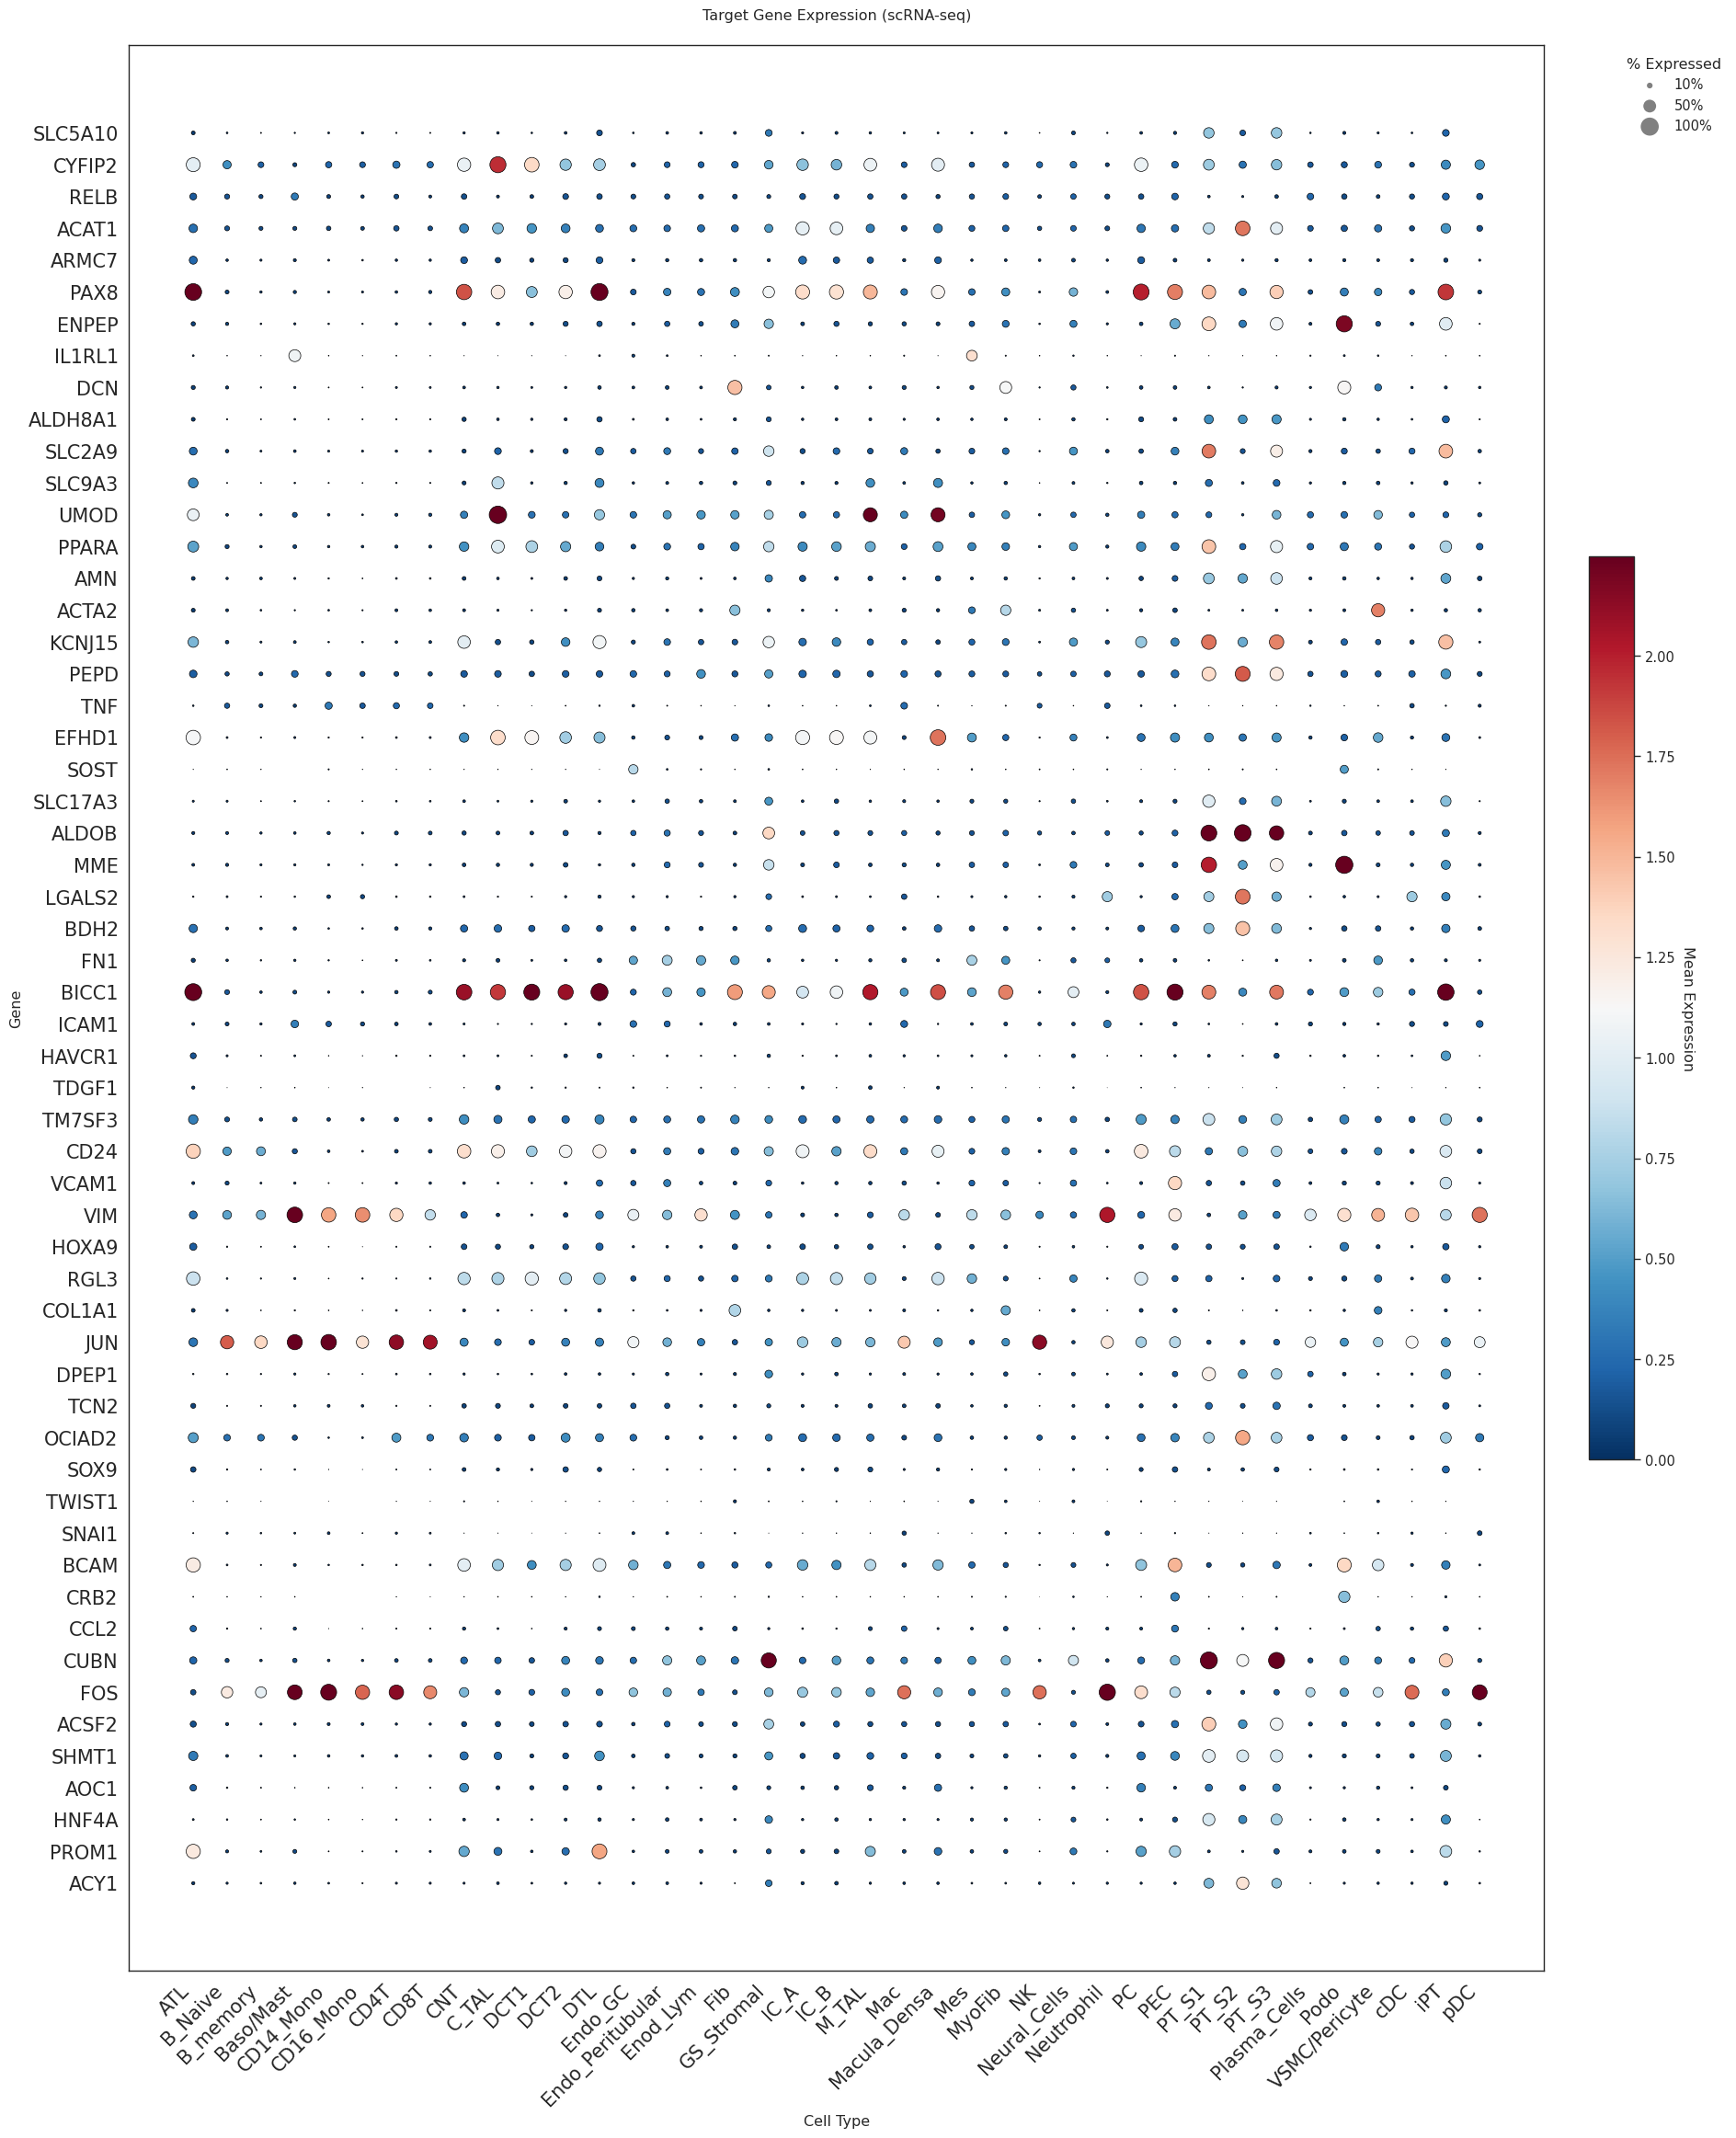

In [ ]:

# ==========================================
# 3. Calculate Dot Plot Stats
# ==========================================
logging.info("Calculating expression stats...")
valid_genes = [g for g in ORDERED_GENES if g in adata_rna.var_names or (
    hasattr(adata_rna, "raw") and g in adata_rna.raw.var_names)]


def get_dotplot_stats(ado, features, group):
    clusters = sorted(ado.obs[group].unique())
    mean_df = pd.DataFrame(index=clusters, columns=features)
    pct_df = pd.DataFrame(index=clusters, columns=features)

    for cl in clusters:
        cells = ado.obs.index[ado.obs[group] == cl]
        # Use raw if available
        X = ado.raw[cells, features].X if hasattr(
            ado, "raw") else ado[cells, features].X
        if hasattr(X, "toarray"):
            X = X.toarray()
        mean_df.loc[cl] = np.mean(X, axis=0)
        pct_df.loc[cl] = np.mean(X > 0, axis=0)

    return mean_df.astype(float), pct_df.astype(float)


mean_df, pct_df = get_dotplot_stats(adata_rna, valid_genes, cluster_col)

# Save Raw Data
mean_df.to_csv(outdir / "Target_Genes_scRNA_Mean.csv")
pct_df.to_csv(outdir / "Target_Genes_scRNA_Pct.csv")

# ==========================================
# 4. Generate Plot (Genes on Rows)
# ==========================================
logging.info("Generating Transposed Dot Plot...")

# Transpose Data for Plotting (Genes x Clusters)
c_values = mean_df.T  # Genes on Index (Rows), Clusters on Columns
s_values = pct_df.T

n_genes = len(c_values.index)
n_clusters = len(c_values.columns)

fig, ax = plt.subplots(figsize=(n_clusters * 0.45 + 1.5, n_genes * 0.4 + 1))

# Create Meshgrid
# X = Clusters (0 to n_clusters)
# Y = Genes (0 to n_genes)
x, y = np.meshgrid(np.arange(n_clusters), np.arange(n_genes))

# Flatten
x_flat = x.flatten()
y_flat = y.flatten()
c_flat = c_values.values.flatten()
s_flat = s_values.values.flatten() * 200  # Size Scale

# Plot
norm = mcolors.Normalize(vmin=0, vmax=np.percentile(c_flat, 99))
scatter = ax.scatter(
    x_flat, y_flat,
    s=s_flat, c=c_flat,
    cmap="RdBu_r", norm=norm,
    edgecolors='black', linewidth=0.5
)

# Axis Formatting
ax.set_xticks(np.arange(n_clusters))
ax.set_xticklabels(c_values.columns, rotation=45, ha='right',
                   fontsize=15)  # 45 Degree Rotation
ax.set_yticks(np.arange(n_genes))
ax.set_yticklabels(c_values.index, fontsize=15)

ax.invert_yaxis()  # Gene 1 at Top
ax.set_title("Target Gene Expression (scRNA-seq)", pad=20)
ax.set_xlabel("Cell Type")
ax.set_ylabel("Gene")

# Legends
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03, pad=0.03)
cbar.set_label("Mean Expression", rotation=270, labelpad=15)

handles = [
    plt.scatter([], [], s=200*0.1, c='gray', edgecolors='none', label='10%'),
    plt.scatter([], [], s=200*0.5, c='gray', edgecolors='none', label='50%'),
    plt.scatter([], [], s=200*1.0, c='gray', edgecolors='none', label='100%')
]
plt.legend(handles=handles, title="% Expressed", bbox_to_anchor=(
    1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig(outdir / "Target_Genes_scRNA_Transposed.png",
            dpi=300, bbox_inches='tight')
plt.savefig(outdir / "Target_Genes_scRNA_Transposed.pdf",
            dpi=300, bbox_inches='tight')

logging.info(f"✅ Plot saved: {outdir}/Target_Genes_scRNA_Transposed.png")
plt.show()
